# Analisis Saham

In [1]:
# Install Library yang diperlukan
!pip install yfinance

## Import Library

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

import math
from sklearn.metrics import mean_squared_error

import joblib
from google.colab import files

from tensorflow.keras.models import load_model
import os
import tensorflow as tf

import zipfile

from tensorflow.keras.callbacks import EarlyStopping

## Modelling untuk 5 saham

In [3]:
# 1. KONFIGURASI PABRIK
daftar_saham = ['BBRI.JK', 'TLKM.JK', 'ASII.JK', 'ANTM.JK', 'ICBP.JK']
window_size = 60
epochs_max = 100  # Kita set tinggi, nanti EarlyStopping yang ngerem

# 2. FUNGSI BANTUAN
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(com=window-1, min_periods=window).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(com=window-1, min_periods=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def create_multivariate_dataset(X, y, time_step=60):
    data_X, data_Y = [], []
    for i in range(len(X) - time_step):
        data_X.append(X[i:(i + time_step)])
        data_Y.append(y[i + time_step])
    return np.array(data_X), np.array(data_Y)

# 3. MESIN LOOPING UTAMA
print(f"🏭 MEMULAI LOOPING (MULTIVARIATE + EARLY STOPPING)...\n")

for stock in daftar_saham:
    print(f"==================================================")
    print(f"🚀 Sedang Memproses: {stock}")

    # --- A. Data Ingestion ---
    # Ambil data sampai hari ini banget
    df = yf.download(stock, start='2015-01-01', end='2025-12-31', progress=False, auto_adjust=True)

    # Ratakan header jika perlu
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    if len(df) == 0:
        print(f"⚠️ Gagal download {stock}, skip...")
        continue

    # --- B. Feature Engineering ---
    df['RSI'] = calculate_rsi(df)
    k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
    d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
    df['MACD'] = k - d
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()

    df_clean = df.dropna()

    # --- C. Scaling ---
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    feature_cols = ['Close', 'RSI', 'MACD', 'Signal']
    target_col = ['Close']

    scaled_features = scaler_X.fit_transform(df_clean[feature_cols])
    scaled_target = scaler_y.fit_transform(df_clean[target_col])

    # --- D. Windowing ---
    X, y = create_multivariate_dataset(scaled_features, scaled_target, window_size)

    # Train Test Split
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    # Kita butuh validation data untuk Early Stopping
    X_test, y_test = X[train_size:], y[train_size:]

    # --- E. Modeling ---
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 4))) # 4 Fitur
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # --- F. Training dengan Early Stopping ---
    callback_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print(f"🏋️ Melatih model {stock}...")
    # Kita pasang validation_data dan callbacks
    history = model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=epochs_max,
                        verbose=0,
                        validation_data=(X_test, y_test),
                        callbacks=[callback_stop])

    # Cek dia berhenti di epoch berapa
    epoch_akhir = len(history.history['loss'])
    print(f"✅ Selesai! Model berhenti optimal di Epoch {epoch_akhir}.")

    # --- G. Saving ---
    nama_bersih = stock.replace('.JK', '')
    model.save(f"model_{nama_bersih}.keras")
    joblib.dump(scaler_X, f"scaler_X_{nama_bersih}.pkl")
    joblib.dump(scaler_y, f"scaler_y_{nama_bersih}.pkl")
    print(f"💾 Aset tersimpan untuk {stock}.\n")

# 4. PACKAGING
print("📦 Memaketkan ke ZIP...")
zip_filename = "Model_Saham_Multivariate_Terbaik.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for stock in daftar_saham:
        nama_bersih = stock.replace('.JK', '')
        # Cek dulu filenya ada gak (jaga-jaga kalau ada saham yg gagal download)
        if os.path.exists(f"model_{nama_bersih}.keras"):
            zipf.write(f"model_{nama_bersih}.keras")
            zipf.write(f"scaler_X_{nama_bersih}.pkl")
            zipf.write(f"scaler_y_{nama_bersih}.pkl")

print(f"✅ SIAP! Mendownload {zip_filename}...")
files.download(zip_filename)

🏭 MEMULAI LOOPING (MULTIVARIATE + EARLY STOPPING)...

🚀 Sedang Memproses: BBRI.JK
🏋️ Melatih model BBRI.JK...
✅ Selesai! Model berhenti optimal di Epoch 31.
💾 Aset tersimpan untuk BBRI.JK.

🚀 Sedang Memproses: TLKM.JK
🏋️ Melatih model TLKM.JK...
✅ Selesai! Model berhenti optimal di Epoch 55.
💾 Aset tersimpan untuk TLKM.JK.

🚀 Sedang Memproses: ASII.JK
🏋️ Melatih model ASII.JK...
✅ Selesai! Model berhenti optimal di Epoch 23.
💾 Aset tersimpan untuk ASII.JK.

🚀 Sedang Memproses: ANTM.JK
🏋️ Melatih model ANTM.JK...
✅ Selesai! Model berhenti optimal di Epoch 28.
💾 Aset tersimpan untuk ANTM.JK.

🚀 Sedang Memproses: ICBP.JK
🏋️ Melatih model ICBP.JK...
✅ Selesai! Model berhenti optimal di Epoch 25.
💾 Aset tersimpan untuk ICBP.JK.

📦 Memaketkan ke ZIP...
✅ SIAP! Mendownload Model_Saham_Multivariate_Terbaik.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluasi

## Prediksi

In [4]:
def prediksi_saham_universal(kode_saham_input):
    # 1. Standarisasi Nama File
    ticker_clean = kode_saham_input.upper().replace('.JK', '')
    ticker_yf = f"{ticker_clean}.JK"

    print(f"\n🔍 Sedang mencari otak AI untuk {ticker_clean}...")

    # 2. Cek Apakah Model Tersedia?
    path_model = f"model_{ticker_clean}.keras"
    path_scaler_X = f"scaler_X_{ticker_clean}.pkl"
    path_scaler_y = f"scaler_y_{ticker_clean}.pkl"

    if not os.path.exists(path_model):
        print(f"❌ MAAF! Model untuk {ticker_clean} tidak ditemukan.")
        return

    # 3. Load Model & Scaler
    print("🧠 Memuat model dan kamus data...")
    try:
        model = load_model(path_model)
        scaler_X = joblib.load(path_scaler_X)
        scaler_y = joblib.load(path_scaler_y)
    except Exception as e:
        print(f"⚠️ File model rusak: {e}")
        return

    # 4. Ambil Data LIVE Terbaru
    print(f"📡 Mengambil data live {ticker_yf}...")
    # Kita ambil data cukup panjang untuk pastikan indikator terhitung benar
    df = yf.download(ticker_yf, period='6mo', progress=False, auto_adjust=True)

    # Ratakan header jika bertumpuk
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    if df.empty or len(df) < 60:
        print("⚠️ Data tidak ditemukan/kurang. Cek koneksi.")
        return

    # 5. Feature Engineering (Indikator)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(com=13, min_periods=14).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(com=13, min_periods=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
    d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
    df['MACD'] = k - d
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()

    df_clean = df.dropna()
    if len(df_clean) < 60:
        print("⚠️ Data bersih kurang.")
        return

    # 6. Siapkan Data Input
    # Ambil 60 hari terakhir dari data 4 FITUR (bukan cuma harga)
    input_features_df = df_clean[['Close', 'RSI', 'MACD', 'Signal']].tail(60)
    # Lakukan scaling, kirim DataFrame agar nama fitur tetap terjaga
    input_scaled = scaler_X.transform(input_features_df)
    input_tensor = tf.constant(input_scaled, dtype=tf.float32)
    input_tensor = tf.reshape(input_tensor, (1, 60, 4))

    # 7. Prediksi
    prediksi_scaled = model.predict(input_tensor, verbose=0)
    prediksi_rupiah = scaler_y.inverse_transform(prediksi_scaled)[0][0]
    harga_terakhir = df_clean['Close'].iloc[-1]

    # Perhitungan tanggal
    tgl_terakhir = df_clean.index[-1]
    str_tgl_terakhir = tgl_terakhir.strftime('%d %B %Y')

    # Tambah 1 hari dulu
    tgl_prediksi = tgl_terakhir + pd.Timedelta(days=1)

    # Cek Hari: 0=Senin, ..., 4=Jumat, 5=Sabtu, 6=Minggu
    # Jika harinya Sabtu (5) atau Minggu (6), geser terus sampai ketemu Senin
    while tgl_prediksi.dayofweek > 4:
        tgl_prediksi += pd.Timedelta(days=1)

    # Format nama hari biar jelas (Opsional, bahasa Inggris default)
    nama_hari = tgl_prediksi.strftime('%A') # Contoh: Monday
    str_tgl_prediksi = tgl_prediksi.strftime('%d %B %Y')

    # 8. Tampilkan Hasil
    selisih = prediksi_rupiah - harga_terakhir
    persentase = (selisih / harga_terakhir) * 100
    arah = "Nanjak 📈" if selisih > 0 else "Longsor 📉"

    print(f"\n========================================")
    print(f"🔮 HASIL PREDIKSI: {ticker_clean}")
    print(f"========================================")
    print(f"📅 Data Terakhir ({str_tgl_terakhir}) : Rp {harga_terakhir:,.2f}")
    print(f"🎯 Target ({nama_hari}, {str_tgl_prediksi}) : Rp {prediksi_rupiah:,.2f}")
    print(f"📊 Selisih                        : {selisih:+,.2f} ({persentase:+.2f}%)")
    print(f"🚦 Kesimpulan                     : {arah}")
    print(f"========================================")

    # 9. Visualisasi
    plt.figure(figsize=(10, 4))
    last_30 = df_clean['Close'].tail(30)
    plt.plot(last_30.index, last_30.values, label='Harga Asli', marker='o')
    plt.scatter(tgl_prediksi, prediksi_rupiah, color='red', s=100, label=f'Prediksi AI ({str_tgl_prediksi})', zorder=5)
    plt.title(f"Tren {ticker_clean} & Ramalan AI")
    plt.grid(True)
    plt.legend()
    plt.show()

Masukan kode saham untuk prediksi : bbri, tlkm, asii, antm, icbp

Masukkan Kode Saham: bbri

🔍 Sedang mencari otak AI untuk BBRI...
🧠 Memuat model dan kamus data...
📡 Mengambil data live BBRI.JK...

🔮 HASIL PREDIKSI: BBRI
📅 Data Terakhir (28 November 2025) : Rp 3,680.00
🎯 Target (Monday, 01 December 2025) : Rp 3,810.10
📊 Selisih                        : +130.10 (+3.54%)
🚦 Kesimpulan                     : Nanjak 📈


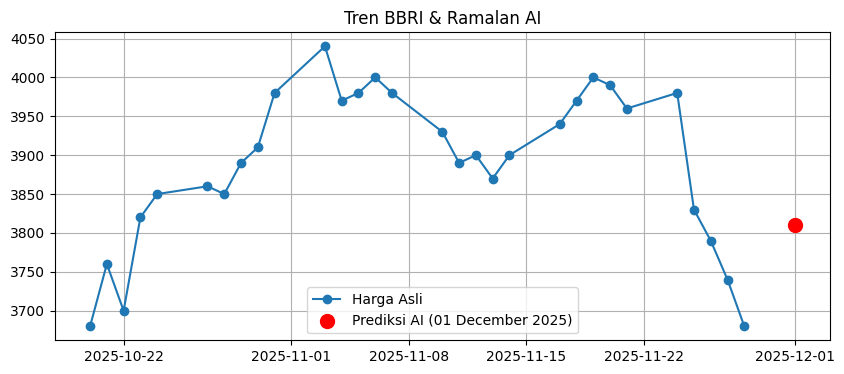


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [5]:
  # Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: tlkm

🔍 Sedang mencari otak AI untuk TLKM...
🧠 Memuat model dan kamus data...
📡 Mengambil data live TLKM.JK...

🔮 HASIL PREDIKSI: TLKM
📅 Data Terakhir (28 November 2025) : Rp 3,510.00
🎯 Target (Monday, 01 December 2025) : Rp 3,528.72
📊 Selisih                        : +18.72 (+0.53%)
🚦 Kesimpulan                     : Nanjak 📈


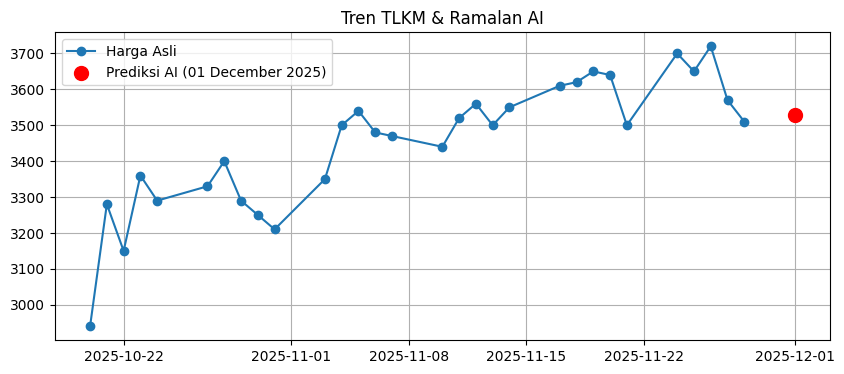


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [6]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: asii

🔍 Sedang mencari otak AI untuk ASII...
🧠 Memuat model dan kamus data...
📡 Mengambil data live ASII.JK...

🔮 HASIL PREDIKSI: ASII
📅 Data Terakhir (28 November 2025) : Rp 6,550.00
🎯 Target (Monday, 01 December 2025) : Rp 6,493.84
📊 Selisih                        : -56.16 (-0.86%)
🚦 Kesimpulan                     : Longsor 📉


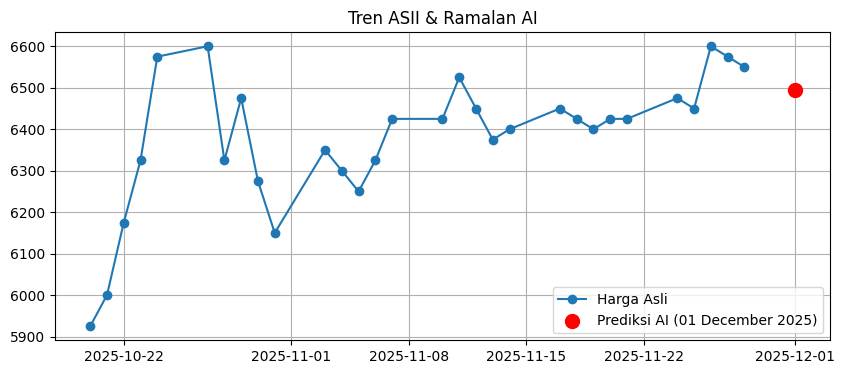


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [7]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: antm

🔍 Sedang mencari otak AI untuk ANTM...
🧠 Memuat model dan kamus data...
📡 Mengambil data live ANTM.JK...

🔮 HASIL PREDIKSI: ANTM
📅 Data Terakhir (28 November 2025) : Rp 2,910.00
🎯 Target (Monday, 01 December 2025) : Rp 2,971.07
📊 Selisih                        : +61.07 (+2.10%)
🚦 Kesimpulan                     : Nanjak 📈


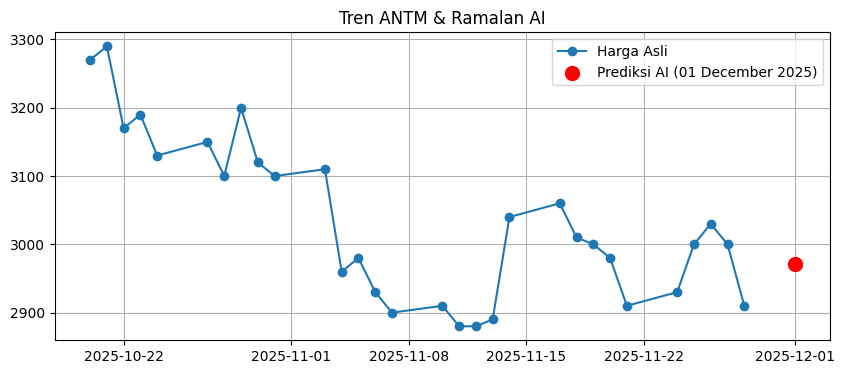


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [8]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: icbp

🔍 Sedang mencari otak AI untuk ICBP...
🧠 Memuat model dan kamus data...
📡 Mengambil data live ICBP.JK...



🔮 HASIL PREDIKSI: ICBP
📅 Data Terakhir (28 November 2025) : Rp 8,450.00
🎯 Target (Monday, 01 December 2025) : Rp 8,565.23
📊 Selisih                        : +115.23 (+1.36%)
🚦 Kesimpulan                     : Nanjak 📈


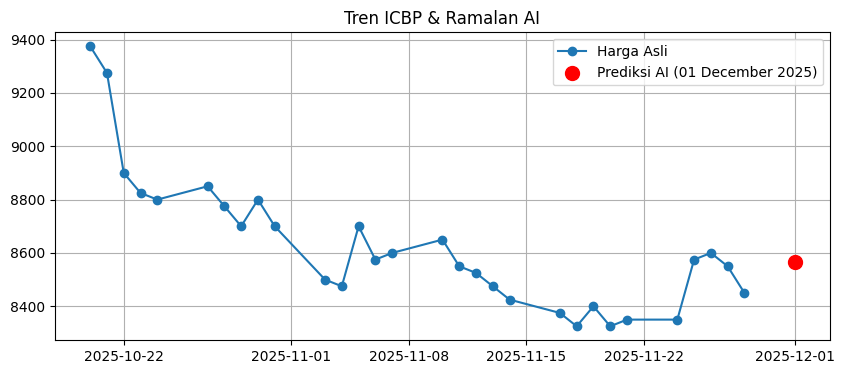


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [9]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")